In [146]:
import pandas as pd
import seaborn as sns
import numpy as np
from nltk.tokenize import regexp_tokenize
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from collections import defaultdict
import re, nltk
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from keras.models import Sequential
from keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.patches as mpatches
import random
from sklearn import metrics
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from keras.layers import SimpleRNN
from keras.layers import LSTM
from keras.layers import GRU
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [147]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt')  # Pobiera tokenizer do dzielenia na zdania, jeśli nie jest już pobrany
nltk.download('omw-1.4')  # Opcjonalnie, dla lepszego wsparcia lematyzacji

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [148]:
#UMICH SI650 - Sentiment Classification
#https://www.kaggle.com/competitions/si650winter11/data

In [149]:
#Read test and train datasets
# header=0 -> first line contains column names
# delimiter=\t -> fields are separated by tabs
# quoting=3 -> ignore double quotes

train_data_df  = pd.read_table('si650winter11/training.txt', names=['sentiment', 'comment'], header=None, delimiter="\t", quoting=3)
test_data_df  = pd.read_table('si650winter11/testdata.txt', names=['comment'], header=None, delimiter="\t", quoting=3)

In [150]:
test_data_df.head(5)

,comment
0,""" I don't care what anyone says, I like Hillar..."
1,have an awesome time at purdue!..
2,"Yep, I'm still in London, which is pretty awes..."
3,"Have to say, I hate Paris Hilton's behavior bu..."
4,i will love the lakers.


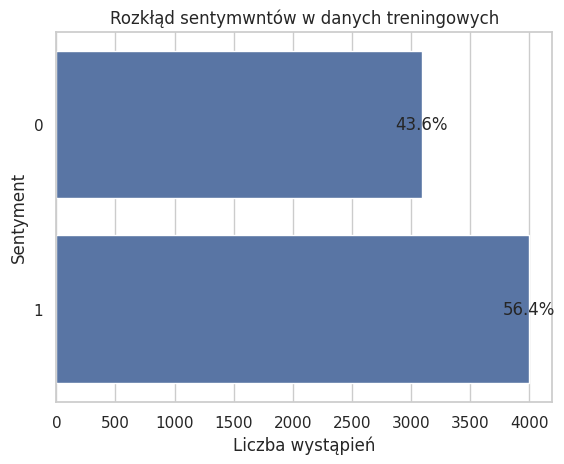

In [151]:
ax = sns.countplot(y="sentiment", data=train_data_df)
ax.set(title="Rozkłąd sentymwntów w danych treningowych", xlabel="Liczba wystąpień", ylabel="Sentyment")
total_freq = len(train_data_df)
for p in ax.patches:
    percentage = f'{100 * p.get_width() / total_freq:.1f}%'
    x = p.get_x() + p.get_width()
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage, (x, y), ha='center', va='center')
plt.show()

In [152]:
#number words per sentence
np.mean([len(s.split(" ")) for s in train_data_df.comment])

10.886819079875812

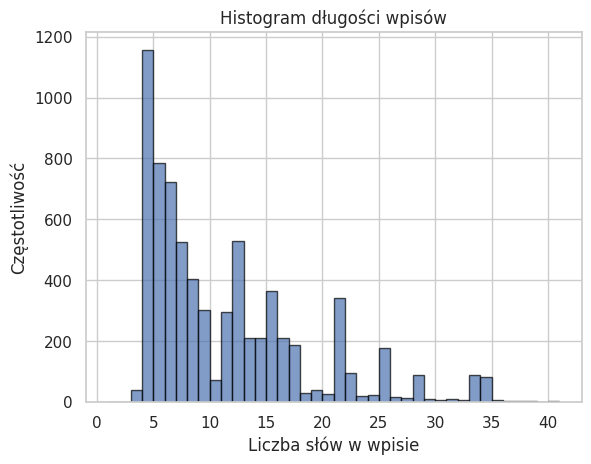

In [153]:
#Make a frequency list of lengths of tokenized each sentences
list_freq = [len(regexp_tokenize(s, "\w+")) for s in train_data_df["comment"]]

# Plot a histogram of the line lengths
#plt.figure(figsize=(8, 6))  # Ustawienie rozmiaru figury
plt.hist(list_freq, bins=range(1, max(list_freq) + 2), edgecolor='black', alpha=0.7)
plt.title("Histogram długości wpisów")
plt.xlabel("Liczba słów w wpisie")
plt.ylabel("Częstotliwość")
plt.show()

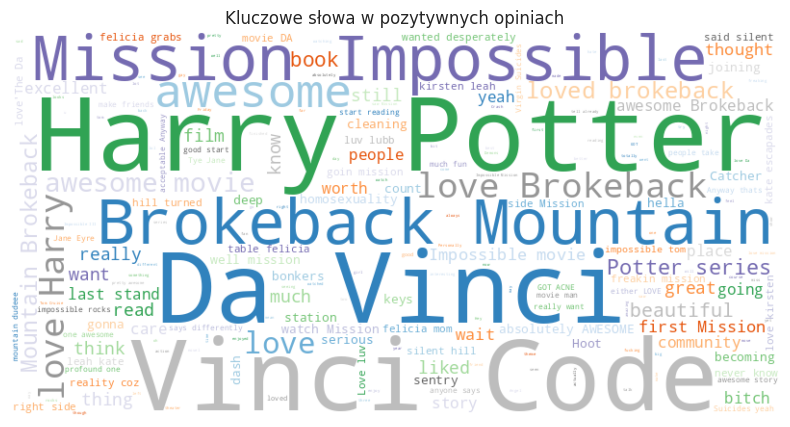

In [154]:
positive_comments = train_data_df[train_data_df['sentiment']==1]['comment']
text = " ".join(review for review in positive_comments)

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='tab20c').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Kluczowe słowa w pozytywnych opiniach")
plt.axis('off')
plt.show()

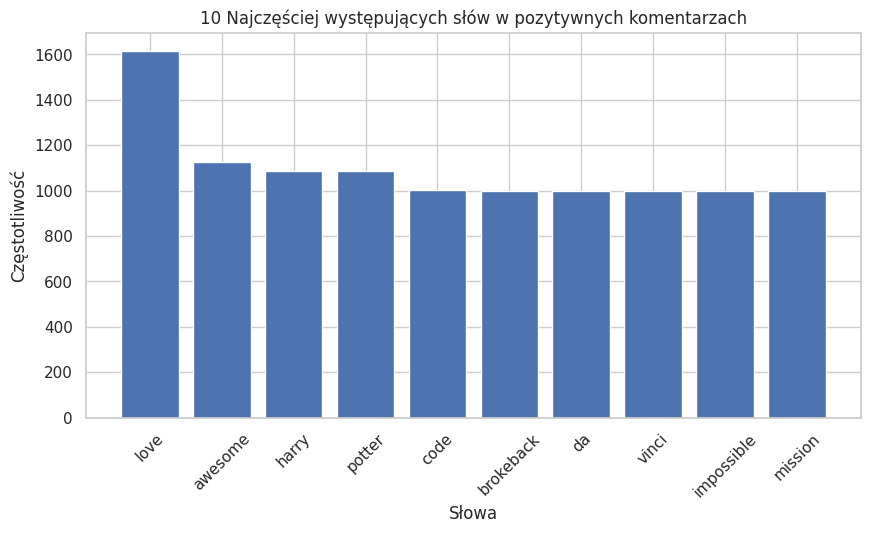

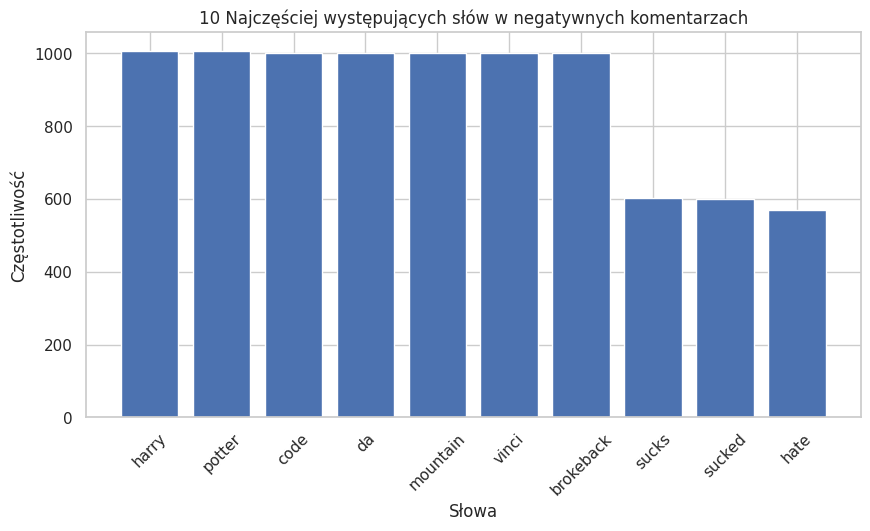

In [155]:
vectorizer = CountVectorizer(stop_words='english')

positive_comments = train_data_df[train_data_df['sentiment'] == 1]['comment']
positive_matrix = vectorizer.fit_transform(positive_comments)
positive_freq = zip(vectorizer.get_feature_names_out(), positive_matrix.sum(axis=0).tolist()[0])
positive_freq = sorted(positive_freq, key=lambda x: -x[1])

negative_comments = train_data_df[train_data_df['sentiment'] == 0]['comment']
negative_matrix = vectorizer.fit_transform(negative_comments)
negative_freq = zip(vectorizer.get_feature_names_out(), negative_matrix.sum(axis=0).tolist()[0])
negative_freq = sorted(negative_freq, key=lambda x: -x[1])

#Create histogram for top frequent words in positive comments
labels_pos, values_pos = zip(*positive_freq[:10])
plt.figure(figsize=(10,5))
plt.bar(labels_pos, values_pos)
plt.title('10 Najczęściej występujących słów w pozytywnych komentarzach')
plt.ylabel('Częstotliwość')
plt.xlabel('Słowa')
plt.xticks(rotation=45)
plt.show()
#Create histogram for top frequent words in negative comments
labels_neg, values_neg = zip(*negative_freq[:10])
plt.figure(figsize=(10,5))
plt.bar(labels_neg, values_neg)
plt.title('10 Najczęściej występujących słów w negatywnych komentarzach')
plt.ylabel('Częstotliwość')
plt.xlabel('Słowa')
plt.xticks(rotation=45)
plt.show()

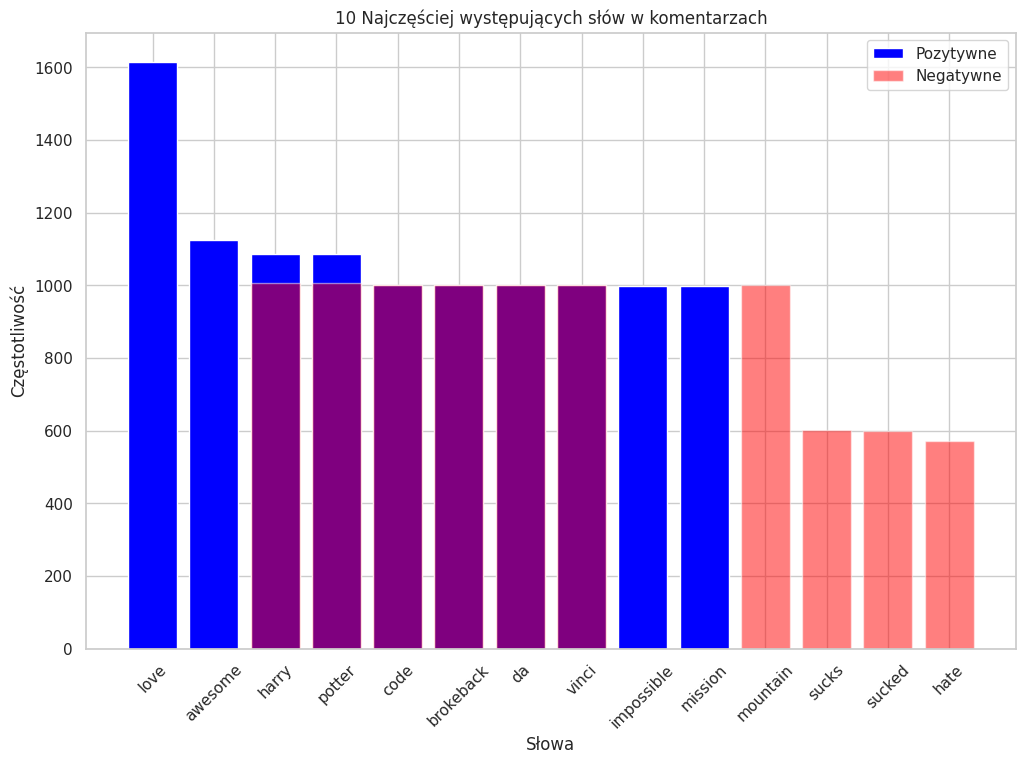

In [156]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(labels_pos, values_pos, color='blue', label='Pozytywne')
ax.bar(labels_neg, values_neg, color='red', label='Negatywne', alpha=0.5)
ax.set_title('10 Najczęściej występujących słów w komentarzach')
ax.set_ylabel('Częstotliwość')
ax.set_xlabel('Słowa')
ax.legend()
plt.xticks(rotation=45)
plt.show()

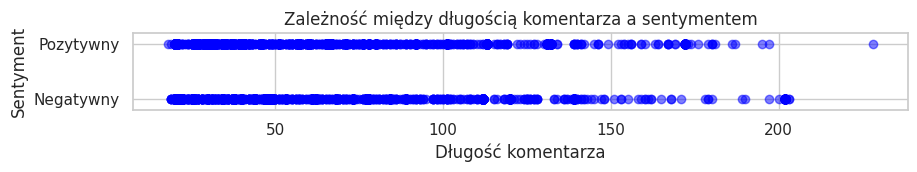

In [157]:
plt.figure(figsize=(10, 1))
plt.scatter(train_data_df['comment'].apply(len), train_data_df['sentiment'], color='blue', alpha=0.5)  # Ustawienie przezroczystości dla lepszej widoczności przy nakładaniu się punktów
plt.title('Zależność między długością komentarza a sentymentem')
plt.xlabel('Długość komentarza')
plt.ylabel('Sentyment')
plt.yticks([0, 1], ["Negatywny", "Pozytywny"])
plt.ylim(-0.2, 1.2)
plt.grid(True)
plt.show()

In [158]:
defaultdict(list)

defaultdict(list, {})

In [159]:
#Dictionary to store sentiment lists for every word
sentiment_dict = defaultdict(list)

rows = []
for _, row in train_data_df.iterrows():
    words = row['comment'].lower().split()
    for word in words:
        sentiment_dict[word].append(row['sentiment'])

def determine_color(sentiments):
    if all(s == 1 for s in sentiments):
        return 'green'
    elif all(s == 0 for s in sentiments):
        return 'red'
    else:
        return 'orange'

color_dict = {word: determine_color(sentiments) for word, sentiments in sentiment_dict.items()}

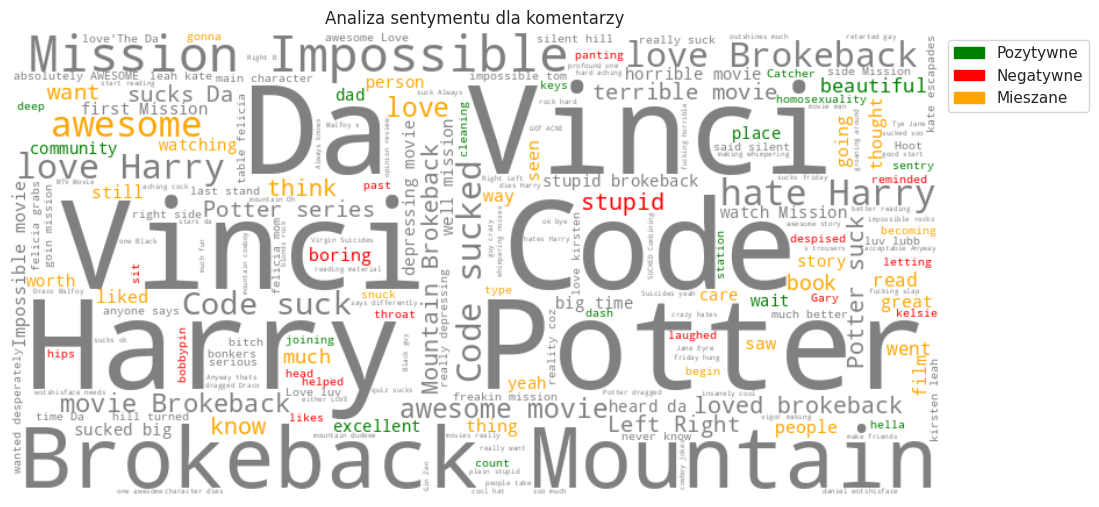

In [160]:
#Function color_func use color dictionary
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return color_dict.get(word.lower(), 'grey')

text = ' '.join(train_data_df['comment'])

wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=color_func).generate(text)
legend_elements = [
    mpatches.Patch(color='green', label='Pozytywne'),
    mpatches.Patch(color='red', label='Negatywne'),
    mpatches.Patch(color='orange', label='Mieszane')
]
plt.figure(figsize=(12, 7))
#plt.subplot(121)  # Użyj subplot, aby zrobić miejsce na legendę
plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Analiza sentymentu dla komentarzy')
plt.axis('off')
plt.show()


In [161]:
#Preprocessing

In [162]:
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

In [163]:
def tokenize(text):
    text = re.sub("[^a-zA-Z]", " ", text) #remove non letters
    tokens = nltk.word_tokenize(text) #tokenize
    stems = stem_tokens(tokens, PorterStemmer()) #stem
    return stems

In [164]:
count_vect = CountVectorizer(analyzer='word', tokenizer=tokenize, lowercase=True, stop_words='english', max_features=100)
#fits the model, model learns the vocabulary and transforms corpus data into feature vectors
comment_tf = count_vect.fit_transform(train_data_df.comment.tolist() + test_data_df.comment.tolist())
#to numpy
comment_tf_nd = comment_tf.toarray()
comment_tf_nd.shape

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', '

(40138, 100)

In [165]:
print("Comments term frequency (CountVectorize): ")
pd.DataFrame(comment_tf_nd, columns=count_vect.get_feature_names_out()).head(5)

Comments term frequency (CountVectorize): 


,aaa,airlin,amaz,angelina,awesom,beauti,becaus,big,boston,brokeback,...,toyota,ucla,ve,vinci,wa,want,way,whi,work,world
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [166]:
tfidf_vect = TfidfVectorizer(analyzer='word', tokenizer=tokenize, lowercase=True, stop_words='english', max_features=100, smooth_idf=False)
comment_tfidf = tfidf_vect.fit_transform(train_data_df.comment.tolist() + test_data_df.comment.tolist())
comment_tfidf_nd = comment_tfidf.toarray()
comment_tfidf_nd.shape

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', '

(40138, 100)

In [167]:
print("Comments term frequency-inverse document frequency (tf-idf):")
pd.DataFrame(comment_tfidf_nd, columns=tfidf_vect.get_feature_names_out()).head(5)

Comments term frequency-inverse document frequency (tf-idf):


,aaa,airlin,amaz,angelina,awesom,beauti,becaus,big,boston,brokeback,...,toyota,ucla,ve,vinci,wa,want,way,whi,work,world
0,0.0,0.0,0.0,0.0,0.391895,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.442319,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.384584,0.310759,0.272596,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.420995,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.420995,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.421334,0.000000,0.0,0.0,0.0,0.0,0.0


In [168]:
#words in vocabulary
vocab = count_vect.get_feature_names_out()
print(vocab)

['aaa' 'airlin' 'amaz' 'angelina' 'awesom' 'beauti' 'becaus' 'big'
 'boston' 'brokeback' 'car' 'citi' 'clinton' 'code' 'cool' 'crappi'
 'cruis' 'd' 'da' 'doe' 'don' 'drive' 'francisco' 'friend' 'fuck' 'fun'
 'geico' 'god' 'good' 'got' 'great' 'guy' 'ha' 'harri' 'harvard' 'hate'
 'hi' 'hilton' 'honda' 'imposs' 'joli' 'just' 'know' 'laker' 'left' 'like'
 'littl' 'london' 'look' 'lot' 'love' 'm' 'macbook' 'make' 'miss'
 'mission' 'mit' 'mountain' 'movi' 'na' 'need' 'new' 'oh' 'onli' 'pari'
 'peopl' 'person' 'potter' 'pretti' 'purdu' 'realli' 'right' 'rock' 's'
 'said' 'san' 'say' 'school' 'seattl' 'shanghai' 'shitti' 'stori' 'stupid'
 'suck' 't' 'thi' 'thing' 'think' 'time' 'tom' 'toyota' 'ucla' 've'
 'vinci' 'wa' 'want' 'way' 'whi' 'work' 'world']


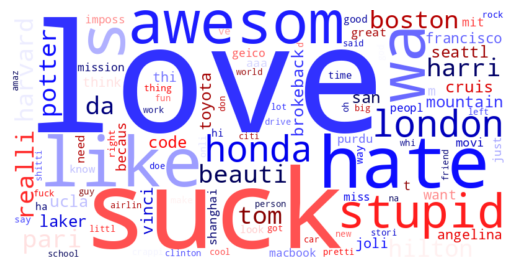

In [169]:
sum_vocab = np.sum(comment_tf_nd, axis=0)
word_frequencies = dict(zip(vocab, sum_vocab))
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap='seismic',).generate_from_frequencies(word_frequencies)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [170]:
# find some good and bad words
df = pd.DataFrame(comment_tf_nd, columns=count_vect.get_feature_names_out())
selected_words = ['awesom', 'good', 'great', 'like', 'shitti', 'stupid', 'suck']
sum_data = dict()
for word in selected_words:
    sum_data[word] = df[word].sum()
#sum_data
df_subset = df[selected_words]
X_train, X_test, y_train, y_test  = train_test_split(df_subset[0:len(train_data_df)], train_data_df.sentiment,
                                                     train_size=0.75, random_state=1,
                                                     stratify=train_data_df.sentiment)

# Create and train the Logistic Regression Classifier
log_sw_model = LogisticRegression()
log_sw_model = log_sw_model.fit(X=X_train, y=y_train)

y_pred = log_sw_model.predict(X=X_test)
y_pred_prob_sw = log_sw_model.predict_proba(X=X_test)[:,1]
fpr_sw, tpr_sw, thresholds = metrics.roc_curve(y_test, y_pred_prob_sw)
roc_auc_sw = metrics.auc(fpr_sw, tpr_sw)

In [171]:
#tf-idf linear classifier
# train and validation set split
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(comment_tfidf_nd[0:len(train_data_df)],
                                                                             train_data_df.sentiment,
                                                                             train_size=0.75,
                                                                             random_state=1,
                                                                             stratify=train_data_df.sentiment)

log_tfidf_model = LogisticRegression()
log_tfidf_model = log_tfidf_model.fit(X=X_train_tfidf, y=y_train_tfidf)
# classifier to label an evaluation set
y_pred_tfidf = log_tfidf_model.predict(X=X_test_tfidf)
y_pred_prob_tfidf = log_tfidf_model.predict_proba(X=X_test_tfidf)[:,1]

print(metrics.classification_report(y_test_tfidf, y_pred_tfidf))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       773
           1       0.98      0.99      0.99       999

    accuracy                           0.98      1772
   macro avg       0.98      0.98      0.98      1772
weighted avg       0.98      0.98      0.98      1772



In [172]:
fpr_tfidf, tpr_tfidf, thresholds = metrics.roc_curve(y_test_tfidf, y_pred_prob_tfidf)
roc_auc_tfidf = metrics.auc(fpr_tfidf, tpr_tfidf)
roc_auc_tfidf

0.9984350456536742

In [173]:
#tf linear classifier
# train and validation set split
X_train_tf, X_test_tf, y_train_tf, y_test_tf  = train_test_split(comment_tf_nd[0:len(train_data_df)],
                                                                 train_data_df.sentiment,
                                                                 train_size=0.75,
                                                                 random_state=1,
                                                                 stratify=train_data_df.sentiment)

log_tf_model = LogisticRegression()
log_tf_model = log_tf_model.fit(X=X_train_tf, y=y_train_tf)
# classifier to label an evaluation set
y_pred_tf = log_tf_model.predict(X=X_test_tf)
y_pred_prob_tf = log_tf_model.predict_proba(X=X_test_tf)[:,1]

print(metrics.classification_report(y_test_tf, y_pred_tf))
fpr_tf, tpr_tf, thresholds = metrics.roc_curve(y_test_tf, y_pred_prob_tf)
roc_auc_tf = metrics.auc(fpr_tf, tpr_tf)
roc_auc_tf

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       773
           1       0.99      0.99      0.99       999

    accuracy                           0.99      1772
   macro avg       0.99      0.99      0.99      1772
weighted avg       0.99      0.99      0.99      1772



0.9978814519564843

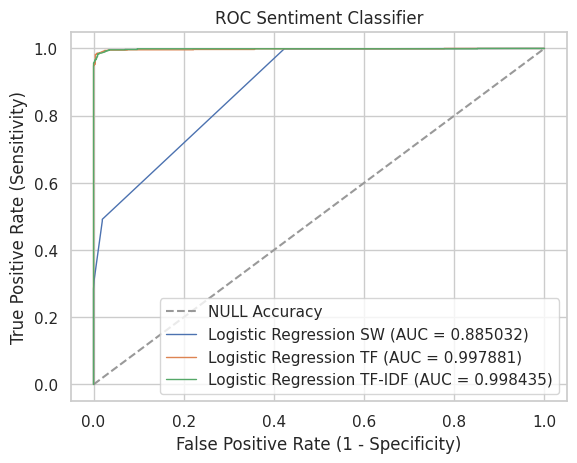

In [174]:
# ROC curves of both the Classifiers
sns.set(style='whitegrid', context='notebook')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.plot(fpr_sw, tpr_sw, lw=1, label='Logistic Regression SW (AUC = %0.6f)' % roc_auc_sw)
plt.plot(fpr_tf, tpr_tf, lw=1, label='Logistic Regression TF (AUC = %0.6f)' % roc_auc_tf)
plt.plot(fpr_tfidf, tpr_tfidf, lw=1, label='Logistic Regression TF-IDF (AUC = %0.6f)' % roc_auc_tfidf)
plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)

In [175]:
comment_tfidf_nd[0:len(train_data_df)]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [176]:
tfidf_vect = TfidfVectorizer(analyzer='word', tokenizer=tokenize, lowercase=True, stop_words='english', max_features=100, smooth_idf=True)
comment_tfidf = tfidf_vect.fit_transform(train_data_df.comment.tolist() + test_data_df.comment.tolist())
comment_tfidf_nd = comment_tfidf.toarray()
comment_tfidf_nd.shape
#tf-idf linear classifier
# train and validation set split
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf  = train_test_split(comment_tfidf_nd[0:len(train_data_df)], train_data_df.sentiment, train_size=0.75, random_state=1, stratify=train_data_df.sentiment)

# Logistic Regression Classifier
log_tfidf_model = LogisticRegression()
log_tfidf_model = log_tfidf_model.fit(X=X_train_tfidf, y=y_train_tfidf)
# classifier to label an evaluation set
y_pred_tfidf = log_tfidf_model.predict(X=X_test_tfidf)
y_pred_prob_tfidf = log_tfidf_model.predict_proba(X=X_test_tfidf)[:,1]
fpr_tfidf_smooth, tpr_tfidf_smooth, thresholds = metrics.roc_curve(y_test_tfidf, y_pred_prob_tfidf)
roc_auc_tfidf_smooth = metrics.auc(fpr_tfidf_smooth, tpr_tfidf_smooth)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', '

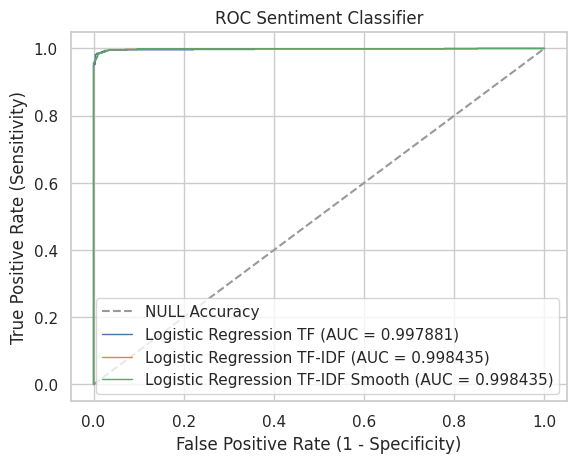

In [177]:
# ROC curves of both the Classifiers
sns.set(style='whitegrid', context='notebook')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.plot(fpr_tf, tpr_tf, lw=1, label='Logistic Regression TF (AUC = %0.6f)' % roc_auc_tf)
plt.plot(fpr_tfidf, tpr_tfidf, lw=1, label='Logistic Regression TF-IDF (AUC = %0.6f)' % roc_auc_tfidf)
plt.plot(fpr_tfidf_smooth, tpr_tfidf_smooth, lw=1, label='Logistic Regression TF-IDF Smooth (AUC = %0.6f)' % roc_auc_tfidf_smooth)
plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)

In [178]:
#predicted unlabelled data
# get predictions
test_pred = log_tfidf_model.predict(comment_tfidf_nd[len(train_data_df):])
# let's sample some of them
spl = random.sample(range(len(test_pred)), 15)

for text, sentiment in zip(test_data_df.comment[spl], test_pred[spl]):
    print(sentiment, text)

0 I'd like to talk today about how much I hate Paris Hilton.....
0 Honda is excellent,'94 and up.
1 She also said she didnt miss her Thanksgiving because Geico was so great and he goes " MASHED POTATOES AND CRANBERRY SAUCE!!!!
0 not only do i hate paris hilton for....
0 I hate Paris Hilton.
1 I LOVE San Francisco, it is one of my favorite cities.
0 stupid, stupid UCLA..
1 I want a tour of London on the back of that bike!
0 I need some of that geico balboa stuff..
1 And I do love my Mastercard.)....
0 As your friendly neighbourhood insurance professional * gag * I can recommend State Farm.
1 UCLA is beautiful.
1 i love shanghai too =).
1 I like honda civics!!!!!!.
0 harvard is dumb, i mean they really have to be stupid to have not wanted her to be at their school.


In [184]:
sia = SentimentIntensityAnalyzer()

train_data_df['vader_score'] = train_data_df['comment'].apply(lambda x: sia.polarity_scores(x)['compound'])
fpr_vader, tpr_vader, thresholds_vader = metrics.roc_curve(train_data_df['sentiment'], train_data_df['vader_score'])
roc_auc_vader = auc(fpr_vader, tpr_vader)

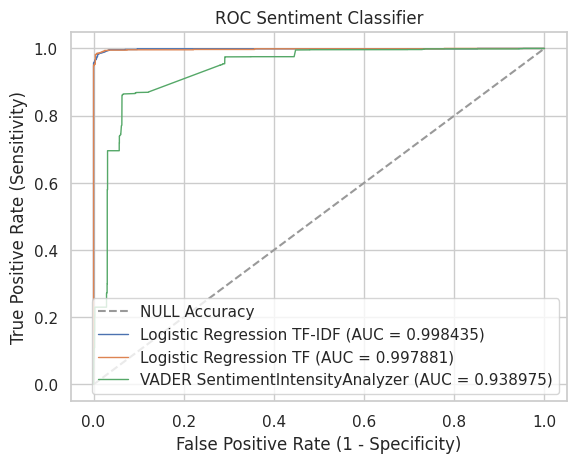

In [185]:
sns.set(style='whitegrid', context='notebook')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.plot(fpr_tfidf, tpr_tfidf, lw=1, label='Logistic Regression TF-IDF (AUC = %0.6f)' % roc_auc_tfidf)
plt.plot(fpr_tf, tpr_tf, lw=1, label='Logistic Regression TF (AUC = %0.6f)' % roc_auc_tf)
plt.plot(fpr_vader, tpr_vader, lw=1, label='VADER SentimentIntensityAnalyzer (AUC = %0.6f)' % roc_auc_vader)
plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)

In [187]:
#Lemmatization with VADER
#Lemmatize the entire text without dividing it into sentences -> This simplifies the process, but may not take into account some of the linguistic nuances that arise from sentence structure.
#Lemmatization without specifying the part of speech

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    word_tokens = word_tokenize(text)
    return ' '.join([lemmatizer.lemmatize(w) for w in word_tokens])

In [191]:
train_data_df['lemmatized_comment'] = train_data_df['comment'].apply(lemmatize_text)

sia = SentimentIntensityAnalyzer()

train_data_df['vader_lemma_score'] = train_data_df['lemmatized_comment'].apply(lambda x: sia.polarity_scores(x)['compound'])
fpr_lemmatizer, tpr_lemmatizer, thresholds = roc_curve(train_data_df['sentiment'], train_data_df['vader_lemma_score'])
roc_auc_lemmatizer = metrics.auc(fpr_lemmatizer, tpr_lemmatizer)

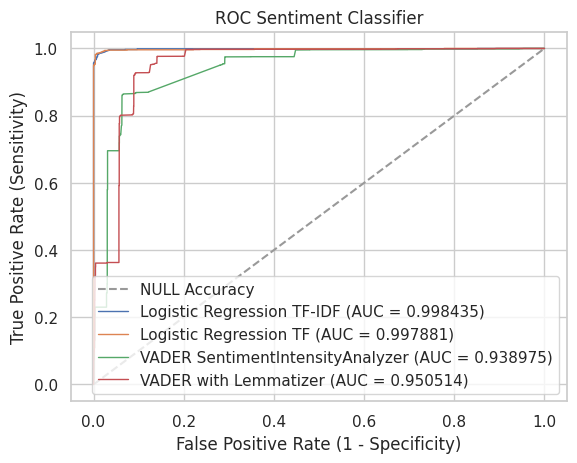

In [193]:
sns.set(style='whitegrid', context='notebook')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.plot(fpr_tfidf, tpr_tfidf, lw=1, label='Logistic Regression TF-IDF (AUC = %0.6f)' % roc_auc_tfidf)
plt.plot(fpr_tf, tpr_tf, lw=1, label='Logistic Regression TF (AUC = %0.6f)' % roc_auc_tf)
plt.plot(fpr_vader, tpr_vader, lw=1, label='VADER SentimentIntensityAnalyzer (AUC = %0.6f)' % roc_auc_vader)
plt.plot(fpr_lemmatizer, tpr_lemmatizer, lw=1, label='VADER with Lemmatizer (AUC = %0.6f)' % roc_auc_lemmatizer)
plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)

In [196]:
#Definition of the lemmatization function divided into sentences
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    sentences = sent_tokenize(text)  # Dzieli tekst na zdania
    lemmatized_output = []

    for sentence in sentences:
        words = word_tokenize(sentence)
        lemmatized_sentence = ' '.join([lemmatizer.lemmatize(word) for word in words])
        lemmatized_output.append(lemmatized_sentence)

    return ' '.join(lemmatized_output)

In [202]:
from nltk.tokenize import sent_tokenize, word_tokenize
# Załóżmy, że 'train_data_df' to DataFrame zawierający kolumnę 'comment'
train_data_df['lemmatized_div_comment'] = train_data_df['comment'].apply(lemmatize_text)

sia = SentimentIntensityAnalyzer()

train_data_df['vader_lemma_div_score'] = train_data_df['lemmatized_div_comment'].apply(lambda x: sia.polarity_scores(x)['compound'])
fpr_lem_div, tpr_lem_div, thresholds = metrics.roc_curve(train_data_df['sentiment'], train_data_df['vader_lemma_div_score'])
roc_auc_lem_div = metrics.auc(fpr_lem_div, tpr_lem_div)

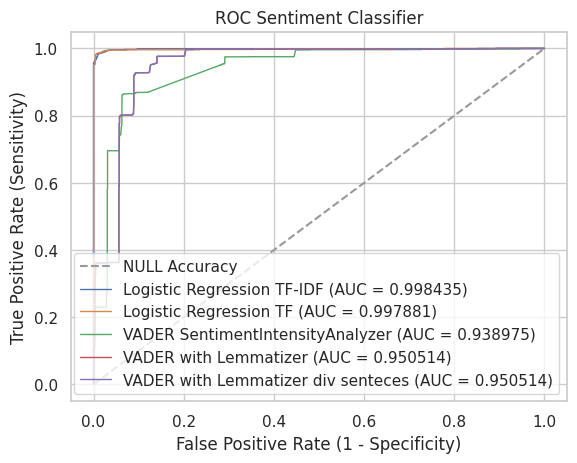

In [204]:
# ROC curves of both the Classifiers
sns.set(style='whitegrid', context='notebook')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.plot(fpr_tfidf, tpr_tfidf, lw=1, label='Logistic Regression TF-IDF (AUC = %0.6f)' % roc_auc_tfidf)
plt.plot(fpr_tf, tpr_tf, lw=1, label='Logistic Regression TF (AUC = %0.6f)' % roc_auc_tf)
plt.plot(fpr_vader, tpr_vader, lw=1, label='VADER SentimentIntensityAnalyzer (AUC = %0.6f)' % roc_auc_vader)
plt.plot(fpr_lemmatizer, tpr_lemmatizer, lw=1, label='VADER with Lemmatizer (AUC = %0.6f)' % roc_auc_lemmatizer)
plt.plot(fpr_lem_div, tpr_lem_div, lw=1, label='VADER with Lemmatizer div senteces (AUC = %0.6f)' % roc_auc_lem_div)
plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)

In [115]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_tfidf, y_train_tfidf)

# classifier to label an evaluation set
y_pred_tfid_knn = knn_model.predict(X=X_test_tfidf)
y_pred_prob_tfidf_knn = knn_model.predict_proba(X=X_test_tfidf)[:,1]
fpr_tfidf_knn, tpr_tfidf_knn, thresholds = metrics.roc_curve(y_test_tfidf, y_pred_prob_tfidf_knn)
roc_auc_tfidf_knn = metrics.auc(fpr_tfidf_knn, tpr_tfidf_knn)

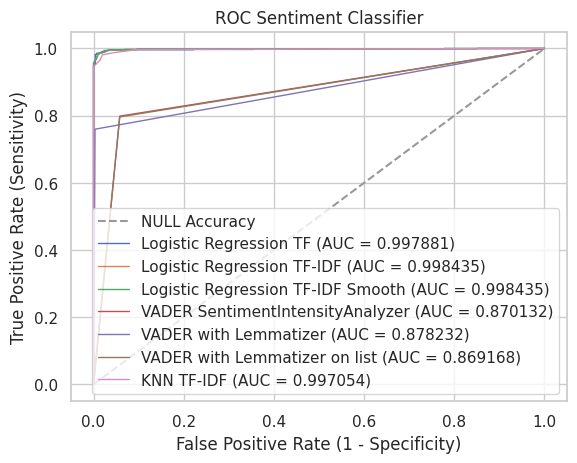

In [116]:
# ROC curves of both the Classifiers
sns.set(style='whitegrid', context='notebook')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.plot(fpr_tf, tpr_tf, lw=1, label='Logistic Regression TF (AUC = %0.6f)' % roc_auc_tf)
plt.plot(fpr_tfidf, tpr_tfidf, lw=1, label='Logistic Regression TF-IDF (AUC = %0.6f)' % roc_auc_tfidf)
plt.plot(fpr_tfidf_smooth, tpr_tfidf_smooth, lw=1, label='Logistic Regression TF-IDF Smooth (AUC = %0.6f)' % roc_auc_tfidf_smooth)
plt.plot(fpr_vader, tpr_vader, lw=1, label='VADER SentimentIntensityAnalyzer (AUC = %0.6f)' % roc_auc_vader)
plt.plot(fpr_lemmatizer, tpr_lemmatizer, lw=1, label='VADER with Lemmatizer (AUC = %0.6f)' % roc_auc_lemmatizer)
plt.plot(fpr_list_lem, tpr_list_lem, lw=1, label='VADER with Lemmatizer on list (AUC = %0.6f)' % roc_auc_list_lem)
plt.plot(fpr_tfidf_knn, tpr_tfidf_knn, lw=1, label='KNN TF-IDF (AUC = %0.6f)' % roc_auc_tfidf_knn)
plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)

In [117]:
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_tfidf, y_train_tfidf)

# classifier to label an evaluation set
y_pred_tfid_dt = dt_model.predict(X=X_test_tfidf)
y_pred_prob_tfidf_dt = dt_model.predict_proba(X=X_test_tfidf)[:,1]
fpr_tfidf_dt, tpr_tfidf_dt, thresholds = metrics.roc_curve(y_test_tfidf, y_pred_prob_tfidf_knn)
roc_auc_tfidf_dt = metrics.auc(fpr_tfidf_dt, tpr_tfidf_dt)

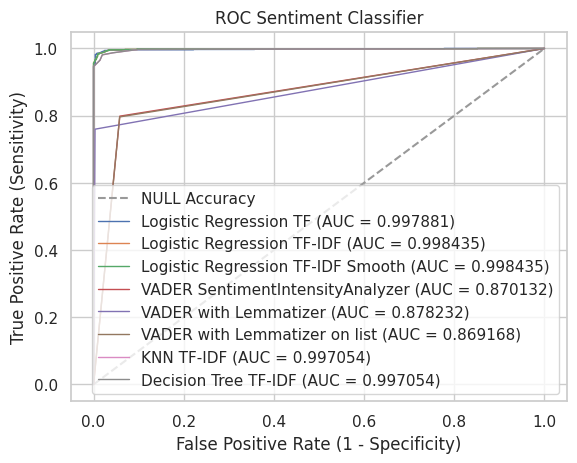

In [118]:
# ROC curves of both the Classifiers
sns.set(style='whitegrid', context='notebook')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.plot(fpr_tf, tpr_tf, lw=1, label='Logistic Regression TF (AUC = %0.6f)' % roc_auc_tf)
plt.plot(fpr_tfidf, tpr_tfidf, lw=1, label='Logistic Regression TF-IDF (AUC = %0.6f)' % roc_auc_tfidf)
plt.plot(fpr_tfidf_smooth, tpr_tfidf_smooth, lw=1, label='Logistic Regression TF-IDF Smooth (AUC = %0.6f)' % roc_auc_tfidf_smooth)
plt.plot(fpr_vader, tpr_vader, lw=1, label='VADER SentimentIntensityAnalyzer (AUC = %0.6f)' % roc_auc_vader)
plt.plot(fpr_lemmatizer, tpr_lemmatizer, lw=1, label='VADER with Lemmatizer (AUC = %0.6f)' % roc_auc_lemmatizer)
plt.plot(fpr_list_lem, tpr_list_lem, lw=1, label='VADER with Lemmatizer on list (AUC = %0.6f)' % roc_auc_list_lem)
plt.plot(fpr_tfidf_knn, tpr_tfidf_knn, lw=1, label='KNN TF-IDF (AUC = %0.6f)' % roc_auc_tfidf_knn)
plt.plot(fpr_tfidf_dt, tpr_tfidf_dt, lw=1, label='Decision Tree TF-IDF (AUC = %0.6f)' % roc_auc_tfidf_dt)
plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)

In [120]:
# Preprocessing parameters
vocab_size = 20000  # Max number of words in dict
max_length = 100    # Max length sequence

# Tokenizer
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train_data_df.comment)

# Convert txt to sequence
X = tokenizer.texts_to_sequences(train_data_df.comment)
X = pad_sequences(X, maxlen=max_length)

y = train_data_df.sentiment.values

# Train, validation set split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [121]:
model_cnn = Sequential([
    Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')
])
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
model_cnn.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

y_pred_prob_cnn = model_cnn.predict(X_test).flatten()
fpr_cnn, tpr_cnn, thresholds = roc_curve(y_test, y_pred_prob_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)

print(f"ROC AUC: {roc_auc_cnn}")


Epoch 1/5
149/149 [==============================] - 5s 29ms/step - loss: 0.2745 - auc: 0.9790 - val_loss: 0.0373 - val_auc: 0.9994
Epoch 2/5
149/149 [==============================] - 4s 30ms/step - loss: 0.0147 - auc: 0.9999 - val_loss: 0.0206 - val_auc: 0.9994
Epoch 3/5
149/149 [==============================] - 5s 32ms/step - loss: 0.0039 - auc: 1.0000 - val_loss: 0.0181 - val_auc: 0.9995
Epoch 4/5
149/149 [==============================] - 4s 27ms/step - loss: 0.0021 - auc: 1.0000 - val_loss: 0.0181 - val_auc: 0.9995
Epoch 5/5
74/74 [==============================] - 0s 5ms/step
ROC AUC: 0.99961949952997


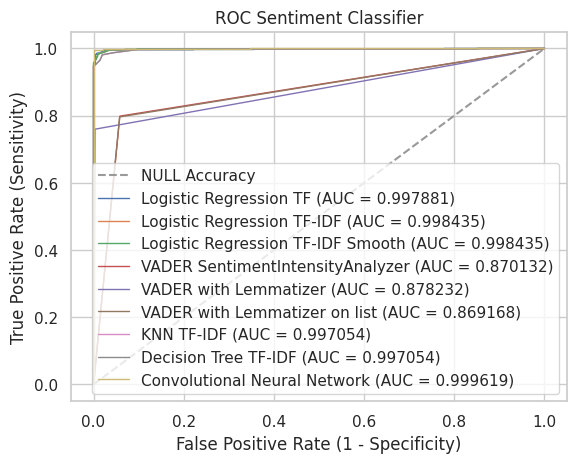

In [122]:
# ROC curves of both the Classifiers
sns.set(style='whitegrid', context='notebook')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.plot(fpr_tf, tpr_tf, lw=1, label='Logistic Regression TF (AUC = %0.6f)' % roc_auc_tf)
plt.plot(fpr_tfidf, tpr_tfidf, lw=1, label='Logistic Regression TF-IDF (AUC = %0.6f)' % roc_auc_tfidf)
plt.plot(fpr_tfidf_smooth, tpr_tfidf_smooth, lw=1, label='Logistic Regression TF-IDF Smooth (AUC = %0.6f)' % roc_auc_tfidf_smooth)
plt.plot(fpr_vader, tpr_vader, lw=1, label='VADER SentimentIntensityAnalyzer (AUC = %0.6f)' % roc_auc_vader)
plt.plot(fpr_lemmatizer, tpr_lemmatizer, lw=1, label='VADER with Lemmatizer (AUC = %0.6f)' % roc_auc_lemmatizer)
plt.plot(fpr_list_lem, tpr_list_lem, lw=1, label='VADER with Lemmatizer on list (AUC = %0.6f)' % roc_auc_list_lem)
plt.plot(fpr_tfidf_knn, tpr_tfidf_knn, lw=1, label='KNN TF-IDF (AUC = %0.6f)' % roc_auc_tfidf_knn)
plt.plot(fpr_tfidf_dt, tpr_tfidf_dt, lw=1, label='Decision Tree TF-IDF (AUC = %0.6f)' % roc_auc_tfidf_dt)
plt.plot(fpr_cnn, tpr_cnn, lw=1, label='Convolutional Neural Network (AUC = %0.6f)' % roc_auc_cnn)
plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)

In [123]:
#Recurrent Neural Network (RNN)

model_rnn = Sequential()
model_rnn.add(Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length))
model_rnn.add(SimpleRNN(units=50))
model_rnn.add(Dense(1, activation='sigmoid'))

model_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
model_rnn.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

y_pred_prob_rnn = model_rnn.predict(X_test).flatten()
fpr_rnn, tpr_rnn, thresholds = roc_curve(y_test, y_pred_prob_rnn)
roc_auc_rnn = auc(fpr_rnn, tpr_rnn)

print(f"ROC AUC: {roc_auc_rnn}")


Epoch 1/5
149/149 [==============================] - 9s 52ms/step - loss: 0.2903 - auc: 0.9580 - val_loss: 0.1364 - val_auc: 0.9912
Epoch 2/5
149/149 [==============================] - 6s 41ms/step - loss: 0.0625 - auc: 0.9986 - val_loss: 0.0961 - val_auc: 0.9947
Epoch 3/5
149/149 [==============================] - 7s 49ms/step - loss: 0.0159 - auc: 0.9999 - val_loss: 0.1065 - val_auc: 0.9959
Epoch 4/5
149/149 [==============================] - 7s 45ms/step - loss: 0.0074 - auc: 1.0000 - val_loss: 0.0608 - val_auc: 0.9972
Epoch 5/5
74/74 [==============================] - 1s 8ms/step
ROC AUC: 0.9978990405419521


In [124]:
#LSTM

model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
model_lstm.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

y_pred_prob_lstm = model_lstm.predict(X_test).flatten()
fpr_lstm, tpr_lstm, thresholds = roc_curve(y_test, y_pred_prob_lstm)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)

print(f"ROC AUC: {roc_auc_lstm}")

Epoch 1/5
149/149 [==============================] - 14s 81ms/step - loss: 0.3255 - auc: 0.9545 - val_loss: 0.0891 - val_auc: 0.9954
Epoch 2/5
149/149 [==============================] - 11s 77ms/step - loss: 0.0380 - auc: 0.9988 - val_loss: 0.0483 - val_auc: 0.9978
Epoch 3/5
149/149 [==============================] - 12s 79ms/step - loss: 0.0170 - auc: 0.9998 - val_loss: 0.0472 - val_auc: 0.9984
Epoch 4/5
149/149 [==============================] - 10s 70ms/step - loss: 0.0052 - auc: 1.0000 - val_loss: 0.0505 - val_auc: 0.9968
Epoch 5/5
74/74 [==============================] - 2s 18ms/step
ROC AUC: 0.9987689690675501


In [125]:
#GRU
model_gru = Sequential()
model_gru.add(Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length))
model_gru.add(GRU(units=50))
model_gru.add(Dense(1, activation='sigmoid'))

model_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_gru.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

y_pred_prob_gru = model_gru.predict(X_test).flatten()
fpr_gru, tpr_gru, thresholds = roc_curve(y_test, y_pred_prob_gru)
roc_auc_gru = auc(fpr_gru, tpr_gru)

print(f"ROC AUC: {roc_auc_gru}")

Epoch 1/5
149/149 [==============================] - 14s 77ms/step - loss: 0.2969 - accuracy: 0.8749 - val_loss: 0.0707 - val_accuracy: 0.9786
Epoch 2/5
149/149 [==============================] - 11s 77ms/step - loss: 0.0291 - accuracy: 0.9933 - val_loss: 0.0477 - val_accuracy: 0.9833
Epoch 3/5
149/149 [==============================] - 10s 66ms/step - loss: 0.0090 - accuracy: 0.9989 - val_loss: 0.0450 - val_accuracy: 0.9850
Epoch 4/5
149/149 [==============================] - 13s 84ms/step - loss: 0.0045 - accuracy: 0.9989 - val_loss: 0.0482 - val_accuracy: 0.9867
Epoch 5/5
74/74 [==============================] - 2s 16ms/step
ROC AUC: 0.9988286554157901


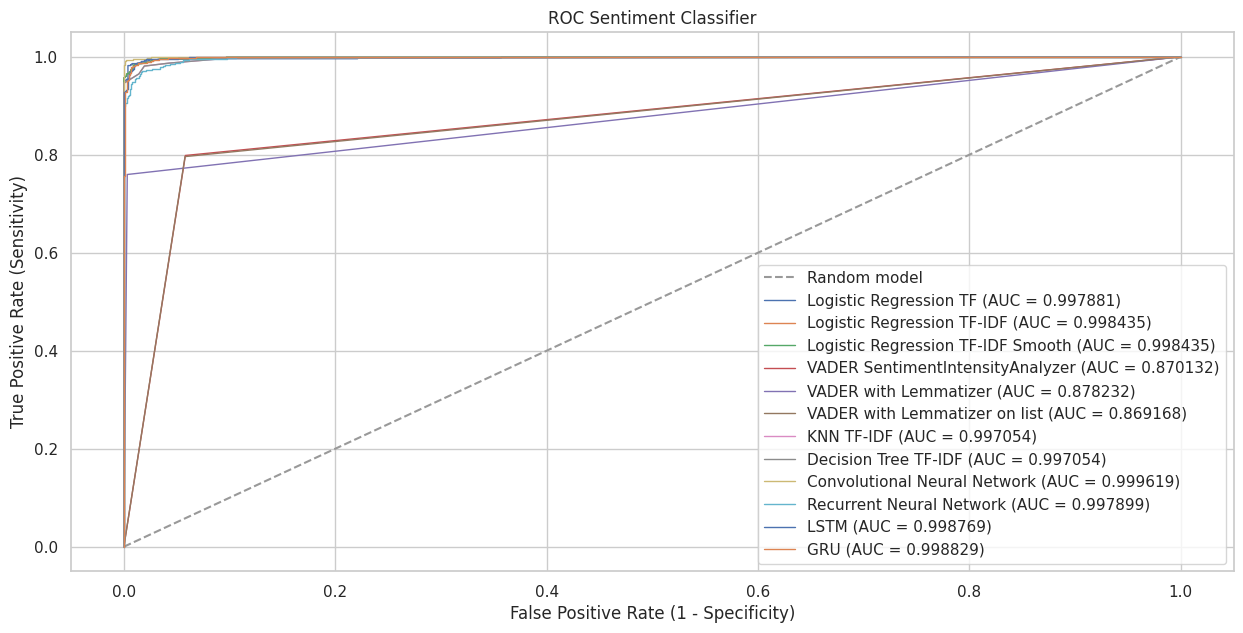

In [129]:
# ROC curves of both the Classifiers
sns.set(style='whitegrid', context='notebook')
plt.figure(figsize=(15, 7))
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random model')
plt.plot(fpr_tf, tpr_tf, lw=1, label='Logistic Regression TF (AUC = %0.6f)' % roc_auc_tf)
plt.plot(fpr_tfidf, tpr_tfidf, lw=1, label='Logistic Regression TF-IDF (AUC = %0.6f)' % roc_auc_tfidf)
plt.plot(fpr_tfidf_smooth, tpr_tfidf_smooth, lw=1, label='Logistic Regression TF-IDF Smooth (AUC = %0.6f)' % roc_auc_tfidf_smooth)
plt.plot(fpr_vader, tpr_vader, lw=1, label='VADER SentimentIntensityAnalyzer (AUC = %0.6f)' % roc_auc_vader)
plt.plot(fpr_lemmatizer, tpr_lemmatizer, lw=1, label='VADER with Lemmatizer (AUC = %0.6f)' % roc_auc_lemmatizer)
plt.plot(fpr_list_lem, tpr_list_lem, lw=1, label='VADER with Lemmatizer on list (AUC = %0.6f)' % roc_auc_list_lem)
plt.plot(fpr_tfidf_knn, tpr_tfidf_knn, lw=1, label='KNN TF-IDF (AUC = %0.6f)' % roc_auc_tfidf_knn)
plt.plot(fpr_tfidf_dt, tpr_tfidf_dt, lw=1, label='Decision Tree TF-IDF (AUC = %0.6f)' % roc_auc_tfidf_dt)
plt.plot(fpr_cnn, tpr_cnn, lw=1, label='Convolutional Neural Network (AUC = %0.6f)' % roc_auc_cnn)
plt.plot(fpr_rnn, tpr_rnn, lw=1, label='Recurrent Neural Network (AUC = %0.6f)' % roc_auc_rnn)
plt.plot(fpr_lstm, tpr_lstm, lw=1, label='LSTM (AUC = %0.6f)' % roc_auc_lstm)
plt.plot(fpr_gru, tpr_gru, lw=1, label='GRU (AUC = %0.6f)' % roc_auc_gru)
plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)